# ANTS  &  BEES CLASSIFICATIONS MODEL

In [56]:
import tqdm as notebook_tqdm

In [57]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.functional as F
import pathlib, os


In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Configuration des transformations

In [59]:
transform_train = transforms.Compose([
                                    transforms.Resize((224,224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(10),
                                    transforms.RandomAffine(0, shear= 10, scale=(0.8,1.2)),
                                    transforms.ColorJitter(brightness=0.2, contrast= 0.2, saturation=0.2),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5,))
])

In [60]:
transform_val = transforms.Compose([ transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))
                                ])

### Importations des données

In [75]:
train_set = datasets.ImageFolder(root='./ants_and_bees-master/train', transform= transform_train)
train_loader = torch.utils.data.DataLoader(dataset= train_set, batch_size=32, shuffle = True)

validation_set = datasets.ImageFolder(root='./ants_and_bees-master/val', transform=transform_val)
validation_loader = torch.utils.data.DataLoader(dataset = validation_set, batch_size=32, shuffle= False)

In [62]:
print(len(train_set))
print(len(validation_set))

244
153


### Convertisseur

In [63]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)   # it is to change 1,28,28 to 28,28,1
    image = image * np.array((0.5,)) + np.array((0.5,))
    image = image.clip(0, 1)
    return image

In [64]:
classe = ('ant', 'bee')

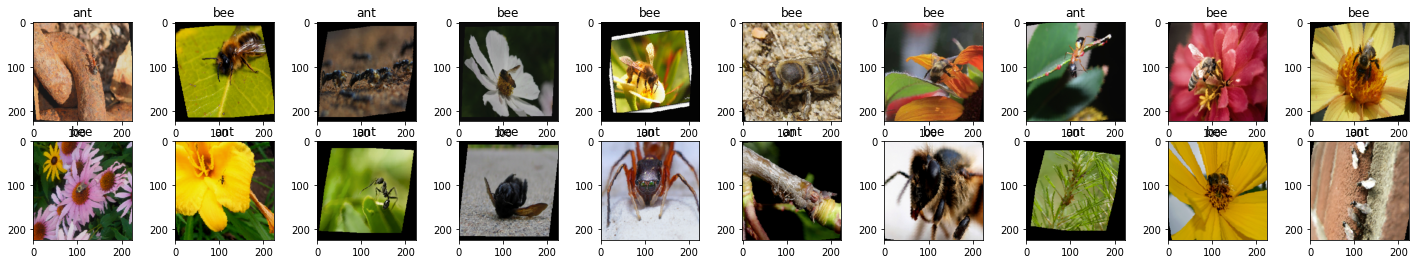

In [65]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx + 1)#, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classe[labels[idx].item()])

### Conception du model

In [66]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)

        self.fc1 = nn.Linear(4*4*64, 500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))

        x = x.view(-1, 4*4*64)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Appel des modeles pré entrtrainés comme VGG16, alexnet

In [96]:
# Faire appel au model alexnet
model = models.alexnet(pretrained =True)

C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [103]:
# Faire appel au model alexnet
model = models.vgg16(pretrained =True)

In [91]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [104]:
for param in model.features.parameters():
    param.requires_grad = False

On remarque que pour classifier de alexnet on a une out_features = 1000
on va donc le reconfigurer a 2 classes dans notre cas

In [105]:
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classe))
model.to(device)
model.classifier[6] = last_layer

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Entrainement du model

In [107]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
epochs = 5

In [108]:
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss  = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()     
        running_corrects += torch.sum(preds == labels.data)
        
        
    else:
        with torch.no_grad():

            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)        
                val_outputs = model(val_inputs)
                val_loss  = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()   
                val_running_corrects += torch.sum(val_preds == val_labels.data)


        # Pour le train
        epoch_loss = running_loss / len(train_loader.dataset)      
        epoch_acc = running_corrects.float() / len(train_loader.dataset)       
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        # Pour la validation
        val_epoch_loss = val_running_loss / len(validation_loader.dataset)      
        val_epoch_acc = val_running_corrects.float() / len(validation_loader.dataset)       
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)



        print('epoch :', (e+1))
        print('trainning loss: {:.4f}, accuracy{:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('Validation loss: {:.4f}, accuracy:{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))
                
    

epoch : 1
trainning loss: 0.0154, accuracy0.7705
Validation loss: 0.0076, accuracy:0.9150
epoch : 2
trainning loss: 0.0060, accuracy0.9221
Validation loss: 0.0066, accuracy:0.9346
epoch : 3
trainning loss: 0.0045, accuracy0.9426
Validation loss: 0.0066, accuracy:0.9216
epoch : 4
trainning loss: 0.0030, accuracy0.9590
Validation loss: 0.0096, accuracy:0.9150
epoch : 5
trainning loss: 0.0022, accuracy0.9713
Validation loss: 0.0111, accuracy:0.9020


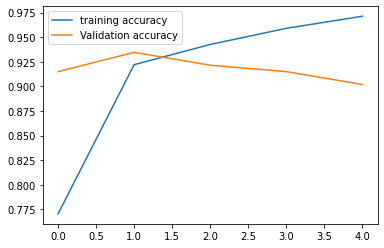

In [109]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'Validation accuracy')
plt.legend()

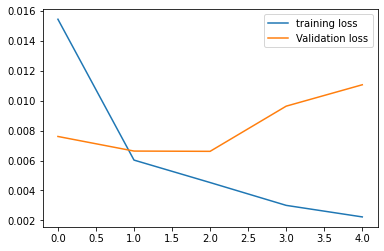

In [110]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'Validation loss')
plt.legend()

# Faire un test avec une image prise sur le net

In [81]:
import PIL.ImageOps
import requests
from PIL import Image

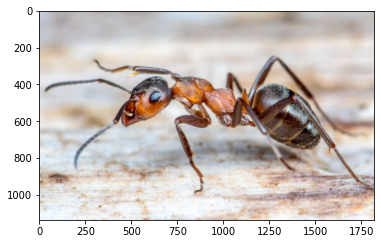

In [83]:
url ="https://cdn.futura-sciences.com/buildsv6/images/wide1920/6/8/7/687e90d197_123198_fourmi-esclavagiste.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

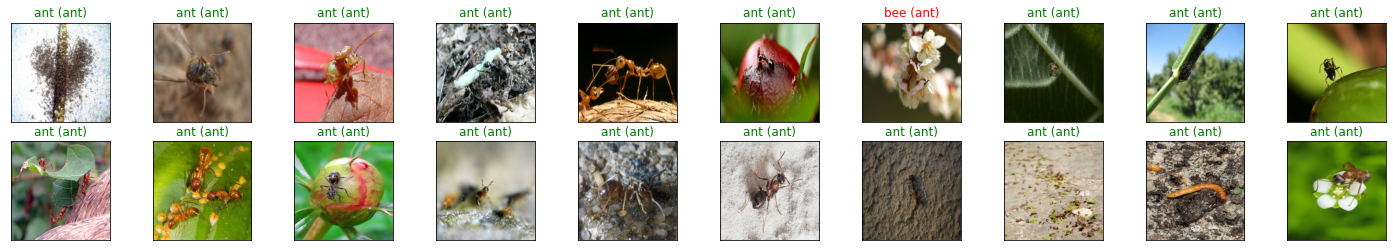

In [111]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx + 1, xticks = [], yticks = [])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(classe[preds[idx].item()]), str(classe[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red"))
    #ax.set_title(classe[preds[idx]], (classe[labels[idx]]))#, color = ("green" if preds[idx]==labels[idx] else "red")
    #plt.Color = ("green" if preds[idx]==labels[idx] else "red")